In [2]:
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
torch.manual_seed(4)
np.random.seed(4)

In [3]:
BATCH_SIZE = 128
NUM_ITERS = int(2e4)
CRITERION = nn.CrossEntropyLoss()  


In [4]:

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)


testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True,  transform=transform)


train_loader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                        shuffle=True, num_workers=2)

test_loader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                        shuffle=False, num_workers=2)

EPOCHS = int(NUM_ITERS / (len(trainset) / BATCH_SIZE))

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(DEVICE)


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
cuda


In [5]:

# Block

class ConvBlock(nn.Module):

    def __init__(self, stride=1, padding=1, batch_norm=False):
        super().__init__()
        self.batch_norm = batch_norm
        
        self.conv1 = nn.Conv2d(in_channels=8, out_channels=8, kernel_size=3, stride=stride, padding=padding)

        if batch_norm:
            self.bn1 = nn.BatchNorm2d(8)

        self.relu1 = nn.ReLU()        

        self.conv2 = nn.Conv2d(in_channels=8, out_channels=8, kernel_size=3, stride=stride, padding=padding)

        if batch_norm:
            self.bn2 = nn.BatchNorm2d(8)

        self.relu2 = nn.ReLU()       

         


    def forward(self, x):

        out = self.conv1(x)

        if self.batch_norm:
            out = self.bn1(out)

        out = self.relu1(out)

        out = self.conv2(x)

        if self.batch_norm:
            out = self.bn2(out)

        out = self.relu2(out)

        return out

# Model
class CNNModel(nn.Module):
    def __init__(self, batch_norm=False, N=10):

        super().__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=5, stride=1, padding=0)
        # Size: 28 x 28

        self.conv2 = nn.Conv2d(in_channels=8, out_channels=8, kernel_size=5, stride=1, padding=0)
        # Size: 24 x 24

        # Dynamic block num
        # self.blocks = nn.Sequential(*[ConvBlock(batch_norm=batch_norm) for _ in range(N)])
        # Size: 24 x 24

        self.conv3 = nn.Conv2d(in_channels=8, out_channels=4, kernel_size=3, stride=2, padding=0)                    
        # Size: 11 X 11

        self.fc1 = nn.Linear(11 * 11 * 4, 100, bias=True) 
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(100, 10) 


    def forward(self, x):

        out = self.conv1(x)
        out = self.conv2(out)
        
        # out = self.blocks(out)         # How is the shape the same after this???
        out = self.conv3(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.relu1(out)
        out = self.fc2(out)

        return out

In [6]:

def calc_accuracy(model, train=False): # add train param to calculate accuracy on both train and test
    # Calculate Accuracy         
    correct = 0
    total = 0
    
    d_loader = train_loader if train else test_loader
    # Iterate through test dataset
    for images, labels in d_loader:
        # Load images
        images, labels = images.to(DEVICE), labels.to(DEVICE)        

        # Forward pass only to get logits/output
        outputs = model(images)

        # Get predictions from the maximum value
        _, predicted = torch.max(outputs.data, 1)

        # Total number of labels
        total += labels.size(0)

        # Total correct predictions
        correct += (predicted == labels).sum()

    return 100 * correct / total

def train(model): 
    print(f'Training for {EPOCHS} epochs')
    optimizer = torch.optim.SGD(model.parameters(), lr=.01)  
    accuracy = {'train': [], 'test': []}

    for epoch in range(EPOCHS):    
        for i, (images, labels) in enumerate(train_loader): 
            # This will load batch_size amount of samples
            images, labels = images.to(DEVICE), labels.to(DEVICE)         
            

            # Clear gradients w.r.t. parameters
            optimizer.zero_grad()

            # Forward pass to get output/logits
            outputs = model(images)

            # Calculate Loss: softmax --> cross entropy loss
            loss = CRITERION(outputs, labels)

            # Getting gradients w.r.t. parameters
            loss.backward()

            # Updating parameters
            optimizer.step()

        train_accuracy = calc_accuracy(model, train=True) # abstract accuracy function away
        test_accuracy = calc_accuracy(model) # abstract accuracy function away
        # Print Loss
        print('Epoch: {} Loss: {}. Train Accuracy: {}, Test Accuracy: {}'.format(epoch, loss.item(), train_accuracy, test_accuracy))

        accuracy['train'].append(train_accuracy.item())
        accuracy['test'].append(test_accuracy.item())
        
    return pd.DataFrame(accuracy)

## a) Plot Train and Test accuracy

Training for 51 epochs
Epoch: 0 Loss: 2.019934892654419. Train Accuracy: 28.833999633789062, Test Accuracy: 28.69999885559082
Epoch: 1 Loss: 1.8260810375213623. Train Accuracy: 33.2599983215332, Test Accuracy: 33.689998626708984
Epoch: 2 Loss: 1.9509941339492798. Train Accuracy: 39.28999710083008, Test Accuracy: 39.15999984741211
Epoch: 3 Loss: 1.686316728591919. Train Accuracy: 42.65599822998047, Test Accuracy: 42.18000030517578
Epoch: 4 Loss: 1.4639712572097778. Train Accuracy: 43.753997802734375, Test Accuracy: 42.939998626708984
Epoch: 5 Loss: 1.8029649257659912. Train Accuracy: 46.06399917602539, Test Accuracy: 44.34000015258789
Epoch: 6 Loss: 1.5325977802276611. Train Accuracy: 47.90599822998047, Test Accuracy: 46.46999740600586
Epoch: 7 Loss: 1.7043771743774414. Train Accuracy: 49.08799743652344, Test Accuracy: 47.209999084472656
Epoch: 8 Loss: 1.291228175163269. Train Accuracy: 50.39999771118164, Test Accuracy: 48.61000061035156
Epoch: 9 Loss: 1.3053247928619385. Train Accuracy

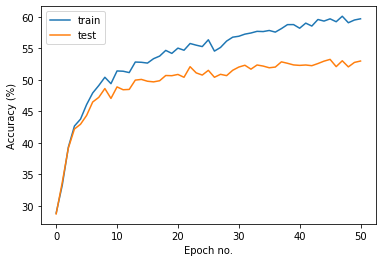

In [7]:

no_batch_norm = CNNModel().to(DEVICE)
nbn_history = train(no_batch_norm)
nbn_history.plot(y=['train', 'test'], use_index=True, xlabel='Epoch no.', ylabel='Accuracy (%)')    

Training for 51 epochs
Epoch: 0 Loss: 1.9546476602554321. Train Accuracy: 28.347999572753906, Test Accuracy: 28.94999885559082
Epoch: 1 Loss: 1.9081859588623047. Train Accuracy: 33.11000061035156, Test Accuracy: 33.099998474121094
Epoch: 2 Loss: 1.6827449798583984. Train Accuracy: 36.694000244140625, Test Accuracy: 36.64999771118164
Epoch: 3 Loss: 1.5484501123428345. Train Accuracy: 41.907997131347656, Test Accuracy: 41.709999084472656
Epoch: 4 Loss: 1.5767314434051514. Train Accuracy: 44.323997497558594, Test Accuracy: 43.30999755859375
Epoch: 5 Loss: 1.4895048141479492. Train Accuracy: 46.18199920654297, Test Accuracy: 45.209999084472656
Epoch: 6 Loss: 1.4594752788543701. Train Accuracy: 47.02000045776367, Test Accuracy: 45.53999710083008
Epoch: 7 Loss: 1.527565360069275. Train Accuracy: 48.652000427246094, Test Accuracy: 46.89999771118164
Epoch: 8 Loss: 1.2248858213424683. Train Accuracy: 49.104000091552734, Test Accuracy: 47.94999694824219
Epoch: 9 Loss: 1.402923345565796. Train Ac

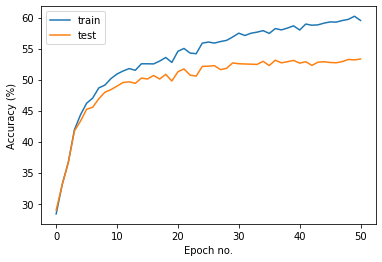

In [8]:
batch_norm = CNNModel(batch_norm=True).to(DEVICE)
bn_history = train(batch_norm)
bn_history.plot(y=['train', 'test'], use_index=True, xlabel='Epoch no.', ylabel='Accuracy (%)')    

## b) Optimal value of N w/o batch normalization

Training for 51 epochs
Epoch: 0 Loss: 2.022226572036743. Train Accuracy: 29.685998916625977, Test Accuracy: 30.229999542236328
Epoch: 1 Loss: 1.8274691104888916. Train Accuracy: 33.55400085449219, Test Accuracy: 33.939998626708984
Epoch: 2 Loss: 1.9232969284057617. Train Accuracy: 38.152000427246094, Test Accuracy: 38.21999740600586
Epoch: 3 Loss: 1.7162954807281494. Train Accuracy: 42.354000091552734, Test Accuracy: 42.189998626708984
Epoch: 4 Loss: 1.3811721801757812. Train Accuracy: 43.157997131347656, Test Accuracy: 42.53999710083008
Epoch: 5 Loss: 1.7078440189361572. Train Accuracy: 44.05799865722656, Test Accuracy: 43.78999710083008
Epoch: 6 Loss: 1.7117490768432617. Train Accuracy: 45.9739990234375, Test Accuracy: 44.62999725341797
Epoch: 7 Loss: 1.4642541408538818. Train Accuracy: 48.003997802734375, Test Accuracy: 46.34000015258789
Epoch: 8 Loss: 1.725035309791565. Train Accuracy: 47.9839973449707, Test Accuracy: 46.44999694824219
Epoch: 9 Loss: 1.5221139192581177. Train Accur

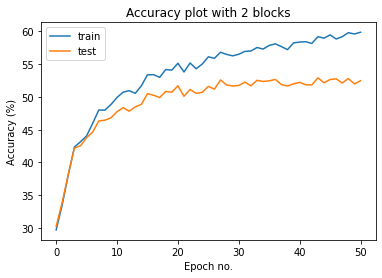

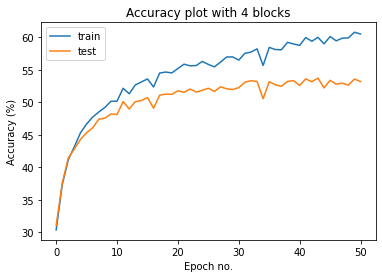

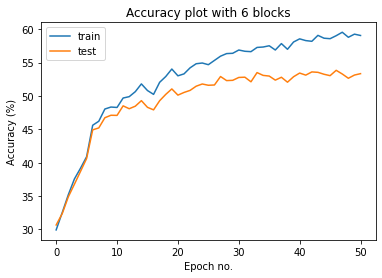

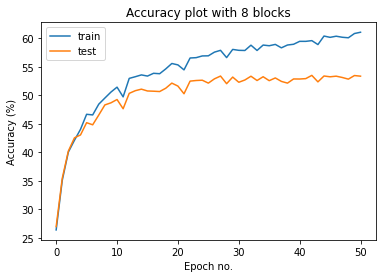

In [9]:
nbn_models = []
nbn_histories = []
for test_n in range(2, 10):
    if test_n % 2 == 0: # if it's even
        model = CNNModel(N=test_n).to(DEVICE)
        nbn_models.append(model)
        history = train(model)
        nbn_histories.append(history)
        history.plot(y=['train', 'test'], use_index=True, xlabel='Epoch no.', ylabel='Accuracy (%)')    
        plt.title(f'Accuracy plot with {test_n} blocks')
    


### Analysis

From these experiments, we can see that _ is the optimal number of blocks when using a CNN without batch normalization. This was a little surprising to me, as I thought that increasing the depth of the model would directly correlate to better performance. However, we see that this isn't really the case.

## c) Plot 2 misclassified and 2 correctly classified samples for each class